In [1]:
import matplotlib.pyplot as plt
import IPython.display
import time
import numpy as np
from skimage.io import imread
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.preprocessing.image import load_img
import os

In [2]:
image_size = 256
content_path = 'content_{}.jpg'.format(image_size)
style_path = 'style2_{}.jpg'.format(image_size)

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1',
                'block4_conv1']#, 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

data_root = 'dataset/train2014/'

batch_size = 5

fileList = [os.path.join(data_root, f) for f in os.listdir(data_root)]

In [3]:
def preprocess(img):
    return tf.keras.applications.vgg16.preprocess_input(img)

def deprocess(processed_img):
    x = processed_img.copy()
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

def get_model():
    vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
    vgg.trainable = False

    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    
    return tf.keras.models.Model(vgg.input, model_outputs)

def get_content_loss(base, target):
    return tf.reduce_mean(tf.square(base - target))

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)
 
def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))

def get_features(model, content, style):
    #stack_images = np.concatenate([style, content], axis=0)
    model_outputs = model(style)
    style_features = [style_layer for style_layer in model_outputs[:num_style_layers]]
    model_outputs = model(content)
    content_features = [content_layer for content_layer in model_outputs[num_content_layers:]]
    return style_features, content_features

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights #, total_variation_weight = loss_weights
    
    model_outputs = model(init_image)
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_content_layers:]
    
    #style_output_features, content_output_features = get_features(model, init_image, init_image)
        
    style_score = 0
    content_score = 0
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content)
    
    style_score *= style_weight
    content_score *= content_weight
    #total_variation_score = total_variation_weight * total_variation_loss(init_image)
    
    loss = style_score + content_score #+ total_variation_score
    
    return loss, style_score, content_score#, total_variation_score

def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

def run_style_transfer(content,
                       style,
                       num_iterations=1000,
                       content_weight=1, 
                       style_weight=1e3,
                       verbose=False): 
    display_num = 200
    # We don't need to (or want to) train any layers of our model, so we set their trainability
    # to false. 
    model = get_model() 

    for layer in model.layers:
        layer.trainable = False

    # Get the style and content feature representations (from our specified intermediate layers) 
    style_features, content_features = get_features(model, content, style)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    # Set initial image
    init_image = tf.Variable(content, dtype=tf.float32)

    # Create our optimizer
    opt = tf.train.AdamOptimizer(learning_rate=9.0)

    # For displaying intermediate images 
    iter_count = 1

    # Store our best result
    best_loss, best_img = float('inf'), None

    # Create a nice config 
    loss_weights = (style_weight, content_weight)#, 1e-2)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    # For displaying
    plt.figure(figsize=(15, 15))
    num_rows = (num_iterations / display_num) // 5
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        # grads, _ = tf.clip_by_global_norm(grads, 5.0)
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time()

        if loss < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = init_image.numpy()

        if i % display_num == 0 and verbose:
            print('Iteration: {}'.format(i))
            print('Total loss: {:.4e}, ' 
                'style loss: {:.4e}, '
                'content loss: {:.4e}, '
                'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
            start_time = time.time()

            # Display intermediate images
            if iter_count > num_rows * 5: continue
            IPython.display.clear_output(wait=True)
            plt.subplot(num_rows, 5, iter_count)
            # Use the .numpy() method to get the concrete numpy array
            plot_img = init_image.numpy()
            plot_img = plot_img.reshape(image_size, image_size, 3)
            plot_img = deprocess(plot_img)
            plt.imshow(np.clip(plot_img, 0, 255).astype('uint8'))
            plt.title('Iteration {}'.format(i + 1))

            iter_count += 1
    print('Total time: {:.4f}s'.format(time.time() - global_start))

    return best_img, best_loss

['dataset/train2014/COCO_train2014_000000361778.jpg', 'dataset/train2014/COCO_train2014_000000498015.jpg', 'dataset/train2014/COCO_train2014_000000517882.jpg', 'dataset/train2014/COCO_train2014_000000211807.jpg', 'dataset/train2014/COCO_train2014_000000422850.jpg', 'dataset/train2014/COCO_train2014_000000184319.jpg', 'dataset/train2014/COCO_train2014_000000244666.jpg', 'dataset/train2014/COCO_train2014_000000405980.jpg', 'dataset/train2014/COCO_train2014_000000483766.jpg', 'dataset/train2014/COCO_train2014_000000366349.jpg']
(10, 256, 256, 3)
(2, 256, 256, 3)


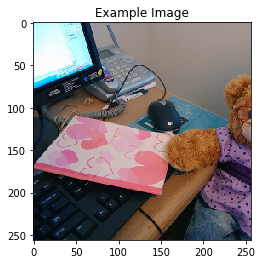

In [4]:
tf.enable_eager_execution()

def imageLoader(files, batch_size):
    L = len(files)
    while True:
        batch_start = 0
        batch_end = batch_size
        
        while batch_start < L:
            limit = min(batch_end, L)
            X = loadImages(files[batch_start:limit])
            
            yield (X, X)
            
            batch_start += batch_size
            batch_end += batch_size

def rescale_and_crop(img):
    if (len(img.shape) == 3):
        img = tf.stack((img, img, img), axis=3)
    _, width, height, _ = img.shape
    width = width.value
    height = height.value
    #width, height = width.value, height.value
    if width > height:
        boxes = [[0.0, 0.0, height/width, 1.0]]
    else:
        boxes = [[0.0, 0.0, 1.0, width/height]]
        
    return tf.image.crop_and_resize(img, boxes=boxes, crop_size=[256, 256], box_ind=[0])

def loadImages(files):
    images = []
    for file in files:
        images.append(rescale_and_crop(tf.expand_dims(imread(file).astype('float32'), 0)))
    return tf.concat(images, axis=0)

file = fileList[10]

print(fileList[:10])
x = loadImages(fileList[:10])

plt.figure()
#x = rescale_and_crop(x)
print(x.shape)
plt.imshow(np.clip(x[0], 0, 255).astype('uint8'))
plt.title('Example Image')

print(loadImages([content_path, style_path]).shape)

float32
float32
(256, 256, 3) (256, 256, 3)


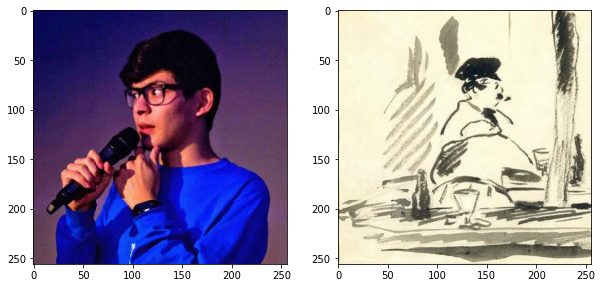

In [ ]:
plt.figure(figsize=(10,10))
content = imread(content_path).astype('float32')
style = imread(style_path).astype('float32')
print(content.dtype)
print(style.dtype)

print(content.shape, style.shape)
#print(content)
plt.subplot(1, 2, 1)
plt.imshow(content.astype('uint8'))
plt.subplot(1, 2, 2)
plt.imshow(style.astype('uint8'))
plt.show()

Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/10
12/12 [==============================] - 23s 2s/step - loss: 51.9339
Epoch 2/10
12/12 [==============================] - 4s 341ms/step - loss: 55.7883
Epoch 3/10
12/12 [==============================] - 4s 348ms/step - loss: 108.9945
Epoch 4/10
12/12 [==============================] - 4s 342ms/step - loss: 58.0003
Epoch 5/10
12/12 [==============================] - 4s 353ms/step - loss: 49.0940
Epoch 6/10
12/12 [==============================] - 4s 356ms/step - loss: 285.5360
Epoch 7/10
12/12 [==============================] - 4s 349ms/step - loss: 36.2628
Epoch 8/10
12/12 [==============================] - 5s 376ms/step - loss: 33.7666
Epoch 9/10
12/12 [==============================] - 4s 372ms/step - loss: 48.7432
Epoch 10/10
12/12 [==============================] - 4s 372ms/step - loss: 34.0880


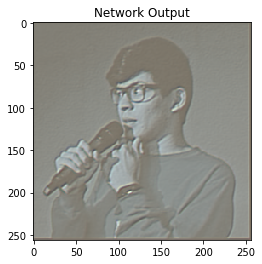

Epoch 1/10
12/12 [==============================] - 4s 350ms/step - loss: 108.2528
Epoch 2/10
12/12 [==============================] - 5s 379ms/step - loss: 28.0319
Epoch 3/10
12/12 [==============================] - 4s 343ms/step - loss: 83.6296
Epoch 4/10
12/12 [==============================] - 4s 357ms/step - loss: 204.1303
Epoch 5/10
12/12 [==============================] - 4s 367ms/step - loss: 59.4047
Epoch 6/10
12/12 [==============================] - 4s 372ms/step - loss: 26.3574
Epoch 7/10
12/12 [==============================] - 4s 355ms/step - loss: 79.8172
Epoch 8/10
12/12 [==============================] - 4s 361ms/step - loss: 40.3704
Epoch 9/10
12/12 [==============================] - 4s 339ms/step - loss: 50.7967
Epoch 10/10
12/12 [==============================] - 4s 366ms/step - loss: 429.5362


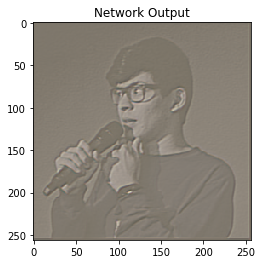

Epoch 1/10
12/12 [==============================] - 4s 355ms/step - loss: 28.5692
Epoch 2/10
12/12 [==============================] - 4s 374ms/step - loss: 32.0239
Epoch 3/10
12/12 [==============================] - 4s 340ms/step - loss: 34.3104
Epoch 4/10
12/12 [==============================] - 4s 352ms/step - loss: 35.2677
Epoch 5/10
12/12 [==============================] - 4s 361ms/step - loss: 74.2157
Epoch 6/10
12/12 [==============================] - 4s 368ms/step - loss: 20.0198
Epoch 7/10
12/12 [==============================] - 4s 347ms/step - loss: 51.6757
Epoch 8/10
12/12 [==============================] - 4s 354ms/step - loss: 59.2752
Epoch 9/10
12/12 [==============================] - 4s 360ms/step - loss: 42.6399
Epoch 10/10
12/12 [==============================] - 4s 355ms/step - loss: 56.3900


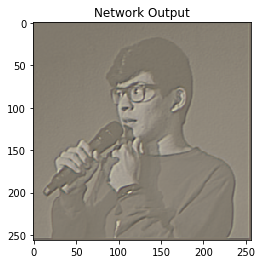

Epoch 1/10
12/12 [==============================] - 4s 352ms/step - loss: 111.1519
Epoch 2/10
12/12 [==============================] - 4s 356ms/step - loss: 122.9515
Epoch 3/10
12/12 [==============================] - 4s 342ms/step - loss: 38.7999
Epoch 4/10
 4/12 [=========>....................] - ETA: 2s - loss: 32.2442

In [ ]:
image_transformation_network = tf.keras.Sequential()

image_transformation_network.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(image_size, image_size, 3)))
image_transformation_network.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
image_transformation_network.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
image_transformation_network.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
image_transformation_network.add(Conv2DTranspose(filters=32, kernel_size=2, padding='same'))
image_transformation_network.add(Conv2DTranspose(filters=32, kernel_size=2, padding='same'))
image_transformation_network.add(Conv2D(filters=3, kernel_size=2, padding='same'))
    
pre_trained_model = get_model()

for layer in pre_trained_model.layers:
    layer.trainable = False
    
repeated_style = preprocess(np.stack([style] * batch_size, 0))
    
def image_transformation_loss(y_true, y_pred):
    #print(out, content_image, repeated_style)

    # Get the style and content feature representations (from our specified intermediate layers) 
    style_features, content_features = get_features(pre_trained_model, preprocess(y_true), repeated_style)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    
    return compute_loss(pre_trained_model, (1e-8, 1e-18), y_pred, gram_style_features, content_features)[0]

optimizer = tf.keras.optimizers.SGD(lr=1e-3, clipnorm=100.)
image_transformation_network.compile(optimizer=optimizer, loss=image_transformation_loss)


steps_per_epoch = 12
epochs = 10
for _ in range(20):
    image_transformation_network.fit_generator(imageLoader(fileList, batch_size), steps_per_epoch=steps_per_epoch, epochs=epochs)
    out = image_transformation_network.predict(content.reshape((1, image_size, image_size, 3)))

    out = out.reshape(image_size, image_size, 3)

    plt.figure()
    
    out = deprocess(out)
    plt.imshow(np.clip(out, 0, 255).astype('uint8'))
    plt.title('Network Output')
    plt.show()
    
    fileList = fileList[(batch_size*steps_per_epoch*epochs):]
    

get features (1, 256, 256, 3) (1, 256, 256, 3)
Total time: 34.8900s


<Figure size 1080x1080 with 0 Axes>

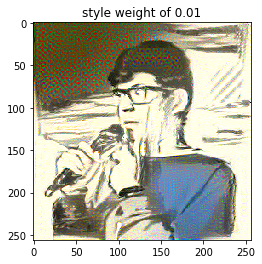

In [25]:
for style_weight in [0.01]:#[1e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1]:
    best, best_loss = run_style_transfer(preprocess(tf.expand_dims(content, 0)), 
                                         preprocess(tf.expand_dims(style, 0)),
                                         style_weight=style_weight)
    plt.figure()
    best = best.reshape(image_size, image_size, 3)
    best = deprocess(best)
    plt.imshow(np.clip(best, 0, 255).astype('uint8'))
    plt.title('style weight of {}'.format(style_weight))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


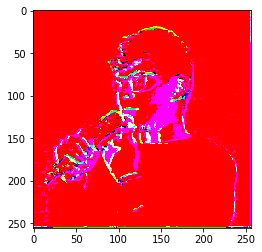

In [327]:
plt.figure()
plt.imshow(out.reshape(image_size, image_size, 3))
plt.show()